<img src="https://risk-engineering.org/static/img/logo-RE.png" width="100" alt="" style="float:right;margin:15px;">

This notebook is an element of the [risk-engineering.org courseware](https://risk-engineering.org/). It can be distributed under the terms of the [Creative Commons Attribution-ShareAlike licence](https://creativecommons.org/licenses/by-sa/4.0/).

Author: Eric Marsden <eric.marsden@risk-engineering.org>

---

In this notebook, we illustrate features of the NumPy, Pandas and statsmodels libraries features for building **linear regression models** in Python. Consult the [accompanying course materials](https://risk-engineering.org/linear-regression-analysis/) for background on linear regression analysis, some notes on when the technique is useful, and to download this content as a Jupyter/Python notebook.

# Linear regression analysis of combined cycle power plant data

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import scipy.stats
plt.style.use("bmh")
%config InlineBackend.figure_formats=["png"]

We will analyze data from a combined cycle power plant to attempt to build a predictive model for output power. The data comes from the UCI machine learning repository.

http://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant

The dataset contains 9568 data points collected from a combined cycle power plant over 6 years, when power plant was under full load. A combined cycle power plant is composed of gas turbines, steam turbines and heat recovery steam generators. Electricity is generated by gas & steam turbines, which are combined in one cycle. Three ambient variables affect the performance of the gas turbine, and exhaust vacuum affects the performance of the steam turbine. 

Data consists of hourly averages taken from various sensors located around the plant that record the ambient variables every second.

Let’s load it into Python and examine it using the `pandas` library. For convenience, we have unzipped the dataset and made it web accessible.

In [2]:
data = pandas.read_csv("https://risk-engineering.org/static/data/CCPP.csv")
data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


The table below provides the meaning of the various columns.

| Meaning | Name | Range |
| --- | --- | --- |
| Ambient Temperature | AT | 1.81 – 37.11°C
| Ambient Pressure | AP |  992.89 – 1033.30 millibar
| Relative Humidity | RH | 25.56% – 100.16%
| Exhaust Vacuum  | V |  25.36 – 81.56 cm Hg
| Net hourly electrical energy output | PE | 420.26 – 495.76 MW |


In [3]:
data.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


## Visualization

We can obtain a first impression of the dependency between variables by examining a multidimensional scatterplot.

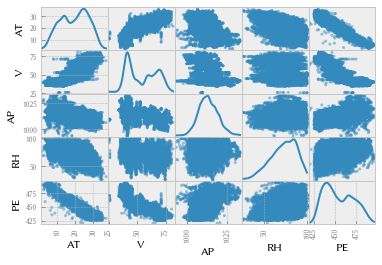

In [4]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, diagonal="kde");

In this matrix, the diagonal contains a plot of the distribution of each variable. We observe that:

- there is an approximately linear relationship between PE and the negative of AT

- there is an approximately linear relationship between PE and negative of V

We can also generate a 3D plot of the observations, which can sometimes help to interpret the data more easily. Here we plot PE as a function of AT and V.

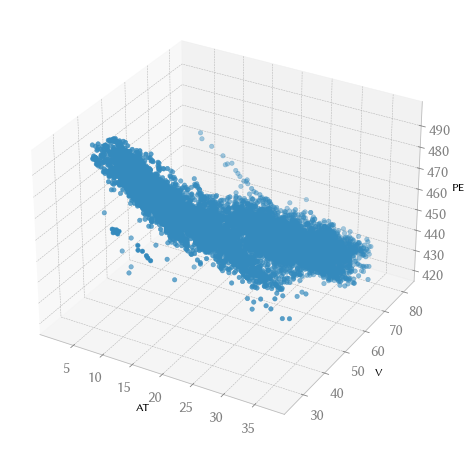

In [5]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)
ax.scatter(data["AT"], data["V"], data["PE"])
ax.set_xlabel("AT")
ax.set_ylabel("V")
ax.set_zlabel("PE")
ax.set_facecolor("white")

## Prediction

We will created a fitted linear model using the formula API of the `statsmodels` library. We use all the observations except for PE as predictor variables in the multiple linear regression.

In [6]:
import statsmodels.formula.api as smf

lm = smf.ols(formula="PE ~ AT + V + AP + RH", data=data).fit()
lm.params

Intercept    454.609274
AT            -1.977513
V             -0.233916
AP             0.062083
RH            -0.158054
dtype: float64

This means that the best formula to estimate output power as a function of AT, V, AP and RH is

$$PE = 451 . 067793 − 1 . 974731   AT − 0 . 234992   V + 0 . 065540   AP − 0 . 157598   RH$$

For any particular observation (values for the predictor variables), we can use the linear model to estimate the output variable PE.

In [7]:
lm.predict(pandas.DataFrame({"AT": [9.48], "V": [44.71], "AP": [1019.12], "RH": [66.43]}))

0    478.174482
dtype: float64

The predicted output power for this combination of inputs is 478 MW (note that we report the result with the same number of significant figures as that in our inputs).

## Residuals plots

We check the residuals of each predictor variable for any pattern that might indicate that a linear model is not appropriate for this dataset.

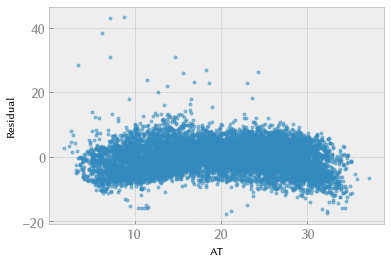

In [8]:
residuals = lm.predict(data) - data.PE
plt.plot(data.AT, residuals, ".", alpha=0.5)
plt.xlabel("AT")
plt.ylabel("Residual");

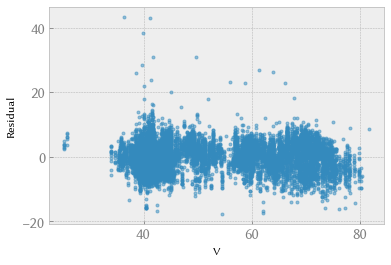

In [9]:
plt.plot(data.V, residuals, ".", alpha=0.5)
plt.xlabel("V")
plt.ylabel("Residual");

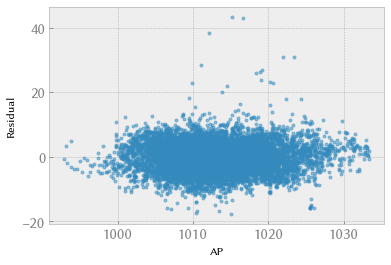

In [10]:
plt.plot(data.AP, residuals, ".", alpha=0.5)
plt.xlabel("AP")
plt.ylabel("Residual");

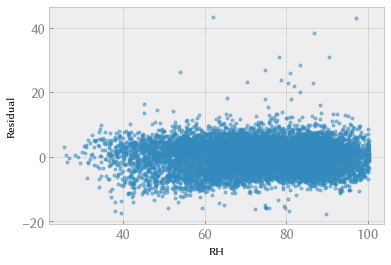

In [11]:
plt.plot(data.RH, residuals, ".", alpha=0.5)
plt.xlabel("RH")
plt.ylabel("Residual");

Indeed, except for a minor quadratic shape to the residuals of variable AT (which we will ignore here), the residuals look random, without any systematic feature apparent that might indicate that our linear model is not appropriate for this data. 

We also check that the variance of the residuals is normally distributed by plotting a histogram or a QQ plot of the residuals, as shown below.

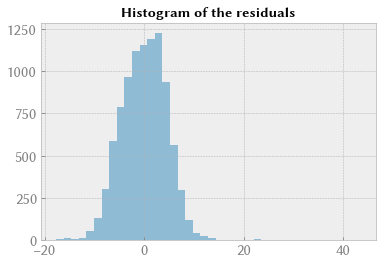

In [12]:
plt.hist(residuals, bins=40, alpha=0.5)
plt.title("Histogram of the residuals", weight="bold");

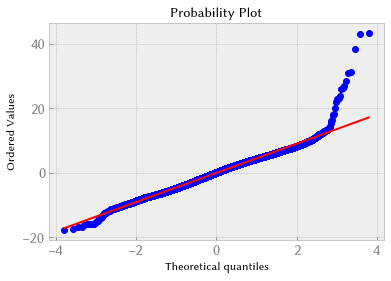

In [13]:
scipy.stats.probplot(residuals, dist=scipy.stats.norm, plot=plt.figure().add_subplot(111));

## Goodness of fit

In [14]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Sat, 28 May 2022   Prob (F-statistic):               0.00
Time:                        09:24:07   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    454.6093      9.749     46.634      0.000     435.500     473.718
AT            -1.9775      0.015   -129.342      0.000      -2.007      -1.948
V             -0.2339      0.007    -32.122      0.000      -0.248      -0.220
AP             0.0621      0.009      6.564      0.000       0.044       0.081
RH            -0.1581      0.004    -37.918      0.000      -0.166      -0.150
==============================================================================
Omnibus:                      892.002   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4086.777
Skew:                          -0.352   Prob(JB):                         0.00
Kurtosis:                       6.123   Cond. No.                     2.13e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The $R^2$ for this model is 0.929, which means that it explains roughly 93% of the variance of the output power. Interpretation of this number is dependent on the application (for instance, models used to understand health effects tend to have lower $R^2$ values than those used for physical models), but is quite satisfactory for this application. 